<a href="https://colab.research.google.com/github/krishnamanc/PytorchPractice/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 44030247.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Define the split sizes
train_size = 48000
val_size = 2000

# Generate a list of indices and split it into train and validation sets
indices = list(range(len(trainset)))
train_indices = indices[:train_size]  # First 55,000 indices for training
val_indices = indices[train_size:train_size + val_size]  # Next 5,000 indices for validation

# Create samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

In [5]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=36, shuffle=False, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=36, shuffle=False, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size=36, shuffle=False)

In [42]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 9, 2, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(9),
            nn.Conv2d(9, 27, 2, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(27),
            nn.Conv2d(27, 81, 2, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(81)
        )

        self.classifier = nn.Sequential(
            nn.Linear(81 * 3 * 3, 128),  # Adjusted input size for the linear layer
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten to the correct size
        x = self.classifier(x)
        return x


In [43]:
del model

In [44]:
model = Model()

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
epochs = 10

The inputs are reshaped using inputs.view(-1, 1, 28, 28) to convert them into the correct 4D format expected by the convolutional layers ([batch_size, channels, height, width]). Adjust the channel dimension (1 in this case) based on your data's actual number of channels. For grayscale images like MNIST, the channel dimension is typically 1. For RGB images, it's 3.

In [48]:
model = torch.load("cifarmodel.pth")

In [49]:
for epoch in range(epochs):
    model.train()  # Set the model in training mode explicitly

    # Train the model
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 3, 32, 32) # Reshape inputs to [batch_size, channels, height, width]

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.2427
Epoch 2/10, Loss: 0.6692
Epoch 3/10, Loss: 1.5916
Epoch 4/10, Loss: 0.1558
Epoch 5/10, Loss: 0.2646
Epoch 6/10, Loss: 0.4339
Epoch 7/10, Loss: 0.3803
Epoch 8/10, Loss: 0.3928
Epoch 9/10, Loss: 0.3169
Epoch 10/10, Loss: 0.5860


In [63]:
correct, total = 0, 0
predictions = []
model.eval()

for i, data in enumerate(val_loader, 0):
  inputs, labels = data
  inputs = inputs.view(-1, 3, 32, 32)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.data, 1)
  predictions.append(outputs)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()

print("Accuracy on validation set : %d %",(100 * correct / total))

Accuracy on validation set : %d % 71.2


In [64]:
correct, total = 0, 0
predictions = []
model.eval()

for i, data in enumerate(test_loader, 0):
  inputs, labels = data
  inputs = inputs.view(-1, 3, 32, 32)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.data, 1)
  predictions.append(outputs)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()

print("Accuracy on test set : %d %",(100 * correct / total))

Accuracy on test set : %d % 70.19


In [52]:
torch.save(model, 'cifarmodel.pth')

Files already downloaded and verified


<ipython-input-62-2730d1c662e5>:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  random_image_resized = random_image_pil.resize((128, 128), Image.ANTIALIAS)


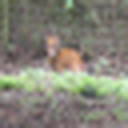

Predicted Class: 8, Actual Class: 4


In [62]:
import random
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
from IPython.display import display

# Define transformations for normalization (for model input)
transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load test dataset without any transformations
testset_original = datasets.CIFAR10(root='./data', train=False, download=True)

# Select a random image from the test dataset
random_idx = random.randint(0, len(testset_original) - 1)
random_image_pil, random_label = testset_original[random_idx]

# Convert the PIL image to a tensor and normalize it
random_image_tensor = transform_normalized(random_image_pil)

# Ensure the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    output = model(random_image_tensor.unsqueeze(0))  # Add batch dimension

# Get the predicted class (assuming it's a classification model)
predicted_class = torch.argmax(output, dim=1).item()

# Resize the original image for better visibility
random_image_resized = random_image_pil.resize((128, 128), Image.ANTIALIAS)

# Display the resized image using PIL
display(random_image_resized)

# Print the predicted and actual class
print(f'Predicted Class: {predicted_class}, Actual Class: {random_label}')


In [ ]:
# from torchsummary import summary
# # Move the model to the GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define the input size as a tuple of integers
# input_size = (3, 32, 32)  # Assuming input size is (channels, height, width)

# # Use torchsummary to print the model summary
# summary(model, input_size=input_size)